# Calibrating Quicksurvey using Gaussian Mixture Models

The goal of this notebook is to use noiseless spectroscopic simulations from `desitarget.select_mock_targets` to calibrate a set of Gaussian mixture models (GMMs) which can be used in turn to simulate much larger datasets just at the catalog level, i.e., *quicksurvey*.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from pkg_resources import resource_filename

In [2]:
from astropy.table import Table
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

In [3]:
from desiutil.sklearn import GaussianMixtureModel
from desitarget.targetmask import desi_mask

In [4]:
import matplotlib.pyplot as plt
import corner as cn

In [5]:
%matplotlib inline

#### Simulation variables

In [6]:
seed = 1
rand = np.random.RandomState(seed)
overwrite = True

### Define some convenience functions for doing the Gaussian mixture modeling.

In [7]:
def get_mog_bic(X, ncomp, rand=None):
    """Compute the MoG and BIC for a range of Gaussian components."""
    mog = [GMM(n_components=nc, random_state=rand).fit(X) for nc in ncomp]
    bic = [_mog.bic(X) for _mog in mog]
    return mog, np.array(bic)

In [8]:
def qa_bic(ncomp, bic, title='Object', png=None):
    ncompbest = ncomp[np.argmin(bic)]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic / 100, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion / 100')
    ax.set_title('{}: Optimal number of components = {:d}'.format(title, ncompbest))
    if png:
        plt.savefig(png)

In [9]:
def build_gmm(X, ncompmin=1, ncompmax=5, target='', 
              rand=None, png=None, overwrite=False):
    """Find the optimal GMM."""

    if rand is None:
        rand = np.random.RandomState()
    ncomp = np.arange(ncompmin, ncompmax)

    gmmfile = resource_filename('desitarget', 'mock/data/quicksurvey_gmm_{}.fits'.format(
        target.lower()))
    if ~os.path.isfile(gmmfile) or overwrite:
        print('Generating GMMs with N={}-{} components from {} objects.'.format(
            ncompmin, ncompmax, X.shape[0]))
        allmog, bic = get_mog_bic(X, ncomp, rand=rand)
        qa_bic(ncomp, bic, png=png, title=target)    
    
        print('Writing {}'.format(gmmfile))
        mog = allmog[np.argmin(bic)] # minimize the BIC
        GaussianMixtureModel.save(mog, gmmfile)

    # (Re)read the model to get a few more convenience methods.
    print('Reading {}'.format(gmmfile))
    mog = GaussianMixtureModel.load(gmmfile)

    return mog

### Read the reference truth catalog.

In [10]:
truthfile = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 
                         'reference_runs', '18.3', 'targets', 'truth.fits')
truth = Table.read(truthfile).to_pandas()
print('Read {} objects from {}'.format(len(truth), truthfile))
truth.head()

Read 240902 objects from /Users/ioannis/work/desi/datachallenge/reference_runs/18.3/targets/truth.fits


,TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,...,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
0,288230398217945088,15594312,0,0.134829,GALAXY,BGS,,3627,1482857632,19.810371,...,5.244956,13.027136,22.072302,17.045567,11.077766,-1.0,0.000000e+00,-1.0,-1.0,-1.0
1,288230398217945089,19713506,0,0.131031,GALAXY,BGS,,3100,1847516324,18.553574,...,23.236532,39.164349,57.429871,52.143738,38.030403,-1.0,1.624847e-15,-1.0,-1.0,-1.0
2,288230398217945090,17928726,0,0.145801,GALAXY,BGS,,1281,1159188526,18.351431,...,19.850098,50.108429,86.518089,74.636200,51.438339,-1.0,0.000000e+00,-1.0,-1.0,-1.0
3,288230398217945091,19762079,0,0.295097,GALAXY,BGS,,5168,1664239784,17.993166,...,18.452414,71.998535,149.989059,178.461807,126.496735,-1.0,0.000000e+00,-1.0,-1.0,-1.0
4,288230398217945092,13979089,0,0.404595,GALAXY,BGS,,6077,236582212,20.154673,...,2.099783,9.958090,21.838903,36.395954,28.041195,-1.0,0.000000e+00,-1.0,-1.0,-1.0


### Define some wrapper functions for reading the data and generating QA.

In [11]:
def get_data(target='ELG', dataframe=False):
    """Build the data matrix."""
    indx = truth['TEMPLATETYPE'].str.contains(target.upper())
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        rmag = 22.5 - 2.5 * np.log10(truth['FLUX_R'].values[indx])
        gr = - 2.5 * np.log10(truth['FLUX_G'].values[indx] / truth['FLUX_R'].values[indx])
        rz = - 2.5 * np.log10(truth['FLUX_R'].values[indx] / truth['FLUX_Z'].values[indx])
        zW1 = - 2.5 * np.log10(truth['FLUX_Z'].values[indx] / truth['FLUX_W1'].values[indx])
        W1W2 = - 2.5 * np.log10(truth['FLUX_W1'].values[indx] / truth['FLUX_W2'].values[indx])
        oii = np.log10(1e17 * truth['OIIFLUX'].values[indx])
        
    if dataframe:
        df = pd.DataFrame()
        df['r'] = rmag
        df['g - r'] = gr
        df['r - z'] = rz
        df['z - W1'] = zW1
        df['W1 - W2'] = W1W2
        if target.upper() == 'ELG':
            df['[OII]'] = oii
        return df
    else:
        nobj = len(indx)
        X = np.vstack( (rmag, gr, rz, zW1, W1W2) )
        if target.upper() == 'ELG':
            X = np.vstack( (X, oii) )
        return X.T

In [12]:
def qa_corner(Xdata, Xsample, target=''):
    labels = list( ['r', 'g - r', 'r - z', 'z - W1', 'W1 - W2'] )
    if target == 'ELG':
        labels.append(r'log$_{10}$ [OII]-17')
    
    fig = cn.corner(Xdata, labels=labels, label_kwargs={"fontsize": 14}, 
                    show_titles=True, title_kwargs={"fontsize": 12},
                    color='k')
    fig.suptitle('{} Validation Data + GMM Samples'.format(target.upper()))
    
    nobj, ndim = Xdata.shape
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.scatter(Xsample[:, xi], Xsample[:, yi], marker='s', 
                       color='g', s=5, alpha=0.5)

In [13]:
def train_and_validate(target, Nsample=500, overwrite=False):
    X = get_data(target)
    Xtrain, Xvalidate = train_test_split(X, test_size=0.5, random_state=rand)
    
    mog = build_gmm(Xtrain, ncompmin=3, ncompmax=40, overwrite=overwrite, 
                    target=target, rand=rand, png=None)
    
    Xsample = mog.sample(Nsample, random_state=rand)
    qa_corner(Xvalidate, Xsample, target=target)
    
    return mog

### ELGs

Train a GMM on *r*, *g-r*, *r-z*, *z-W1*, *W1-W2*, and *[OII] flux*.

Generating GMMs with N=3-40 components from 40752 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_elg.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_elg.fits
CPU times: user 24min 14s, sys: 34.8 s, total: 24min 48s
Wall time: 6min 20s


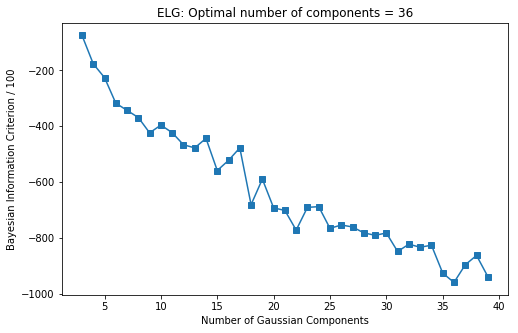

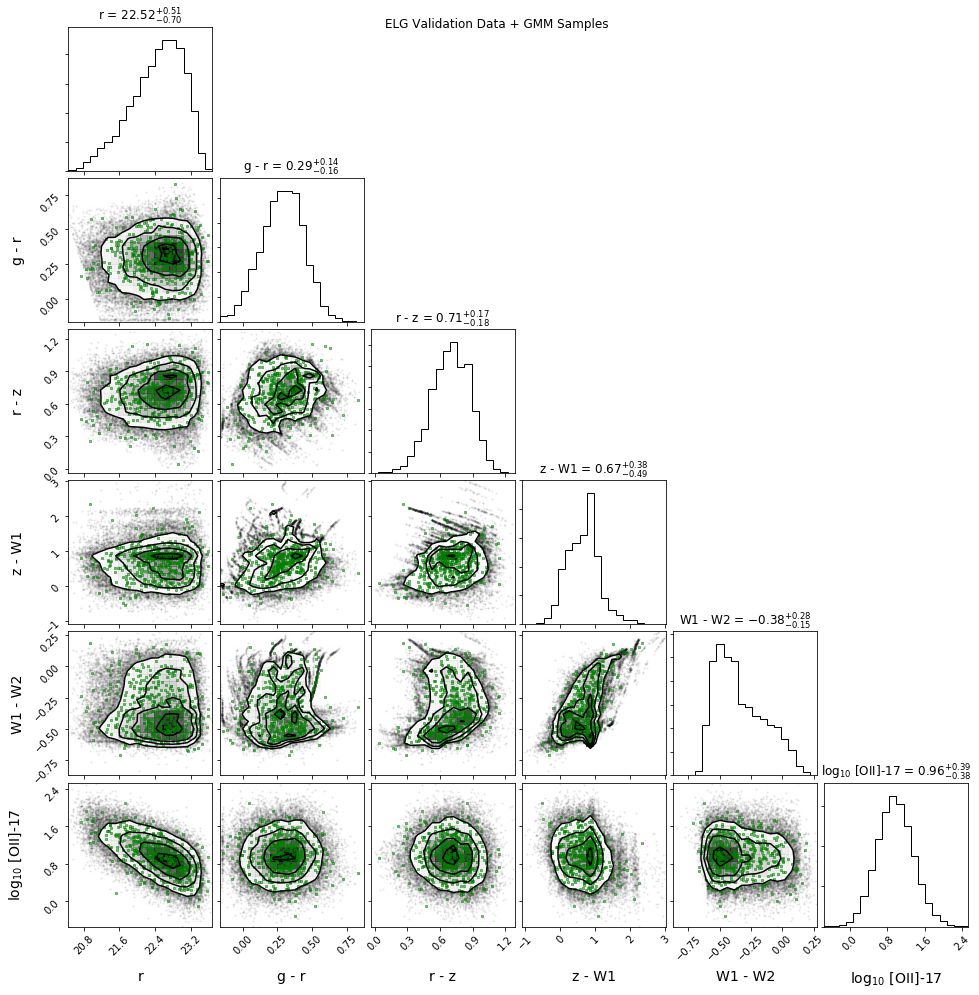

In [14]:
%time mog = train_and_validate('ELG', Nsample=500, overwrite=overwrite)